Install Required Packages

In [ ]:
!pip install torch torchvision kaggle pillow tqdm matplotlib seaborn scikit-learn

In [ ]:
import os
from google.colab import files

In [ ]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.74 GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import time
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Setup Kaggle API and Download Datset

In [ ]:
# Upload your kaggle.json file
print("Upload your kaggle.json file (from https://www.kaggle.com/settings)")
uploaded = files.upload()

Upload your kaggle.json file (from https://www.kaggle.com/settings)


Saving kaggle.json to kaggle.json


In [ ]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download PlantVillage dataset
print("\nDownloading PlantVillage Dataset...")
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d dataset

print("Dataset downloaded and extracted!")
print("\nDataset structure:")
!ls dataset/


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:20<00:00, 195MB/s]
100% 2.04G/2.04G [00:20<00:00, 106MB/s]
Dataset downloaded and extracted!

Dataset structure:
'plantvillage dataset'


In [ ]:
print(os.listdir('/content/dataset/plantvillage dataset/'))

['color', 'segmented', 'grayscale']


In [ ]:
print("Total number of classes are: ", len(os.listdir('/content/dataset/plantvillage dataset/color/')))
print(os.listdir('/content/dataset/plantvillage dataset/color/'))

38
['Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___healthy', 'Potato___Late_blight', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy', 'Apple___Black_rot', 'Soybean___healthy', 'Strawberry___healthy', 'Peach___Bacterial_spot', 'Apple___healthy', 'Tomato___Late_blight', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Tomato___Septoria_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Tomato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Squash___Powdery_mildew', 'Apple___Apple_scab', 'Pepper,_bell___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight',

In [ ]:
print("Total number of classes are: ", len(os.listdir('/content/dataset/plantvillage dataset/grayscale/')))
print(os.listdir('/content/dataset/plantvillage dataset/grayscale/'))

38
['Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___healthy', 'Potato___Late_blight', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy', 'Apple___Black_rot', 'Soybean___healthy', 'Strawberry___healthy', 'Peach___Bacterial_spot', 'Apple___healthy', 'Tomato___Late_blight', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Tomato___Septoria_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Tomato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Squash___Powdery_mildew', 'Apple___Apple_scab', 'Pepper,_bell___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight',

In [ ]:
print("Total number of classes are: ", len(os.listdir('/content/dataset/plantvillage dataset/segmented/')))
print(os.listdir('/content/dataset/plantvillage dataset/segmented/'))

38
['Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___healthy', 'Potato___Late_blight', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy', 'Apple___Black_rot', 'Soybean___healthy', 'Strawberry___healthy', 'Peach___Bacterial_spot', 'Apple___healthy', 'Tomato___Late_blight', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Tomato___Septoria_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Tomato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Squash___Powdery_mildew', 'Apple___Apple_scab', 'Pepper,_bell___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight',

In [ ]:
number_of_images = 0
for i in os.listdir('/content/dataset/plantvillage dataset/color'):
  number_of_images += len(os.listdir('/content/dataset/plantvillage dataset/color/' + i))
print(number_of_images + 1)

54306


In [ ]:
print(len(os.listdir('/content/dataset/plantvillage dataset/color/Apple___Apple_scab')))
print(os.listdir('/content/dataset/plantvillage dataset/color/Apple___Apple_scab')[5])

630
4be9d1d9-2170-4856-a81e-e53e7aa5dbf7___FREC_Scab 3082.JPG


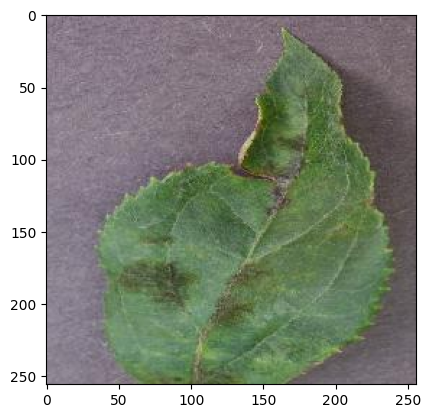

In [ ]:
image_path = '/content/dataset/plantvillage dataset/color/Apple___Apple_scab/5cd3df15-31a2-4076-9d1a-8735fa1dccdf___FREC_Scab 3410.JPG'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(256, 256, 3)

array([[[144, 130, 145],
        [143, 129, 144],
        [142, 128, 143],
        ...,
        [105,  90,  97],
        [109,  94, 101],
        [111,  96, 103]],

       [[135, 121, 136],
        [135, 121, 136],
        [135, 121, 136],
        ...,
        [114,  99, 106],
        [115, 100, 107],
        [115, 100, 107]],

       [[138, 124, 139],
        [135, 121, 136],
        [136, 122, 137],
        ...,
        [118, 103, 110],
        [116, 101, 108],
        [115, 100, 107]],

       ...,

       [[141, 133, 146],
        [147, 139, 152],
        [150, 142, 155],
        ...,
        [123, 112, 120],
        [119, 108, 116],
        [115, 104, 112]],

       [[149, 141, 154],
        [149, 141, 154],
        [147, 139, 152],
        ...,
        [122, 111, 119],
        [124, 113, 121],
        [125, 114, 122]],

       [[139, 131, 144],
        [135, 127, 140],
        [131, 123, 136],
        ...,
        [114, 103, 111],
        [121, 110, 118],
        [127, 116, 124]]], dtype=uint8)
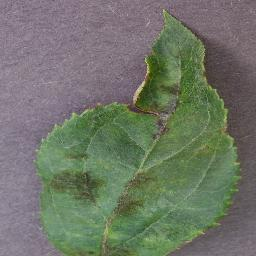

In [ ]:
img

In [ ]:
# Configuration
CONFIG = {
    'IMG_SIZE': 256,
    'BATCH_SIZE': 256,
    'EPOCHS': 20,
    'LEARNING_RATE': 0.001,
    'TRAIN_SPLIT': 0.8,
    'VAL_SPLIT': 0.2,
    'NUM_WORKERS': 2,
    'SEED': 42
}

# Set random seed for reproducibility
torch.manual_seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])

In [ ]:
base_dir = '/content/dataset/plantvillage dataset/'
dataset_type = "color"

data_dir = os.path.join(base_dir, dataset_type)


Data Preparation and Augmentation

In [ ]:
 #Data transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(CONFIG['IMG_SIZE'], scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
])

In [ ]:
# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load dataset
print("\nLoading dataset...")
# full_dataset = datasets.ImageFolder(base_dir, transform=train_transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# # Split ratios
# train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
# dataset_size = len(full_dataset)
# train_size = int(train_ratio * dataset_size)
# val_size = int(val_ratio * dataset_size)
# test_size = dataset_size - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(
#     full_dataset, [train_size, val_size, test_size],
#     generator=torch.Generator().manual_seed(42)  # For reproducibility
# )


Loading dataset...


In [ ]:
# Split into train and validation
train_size = int(CONFIG['TRAIN_SPLIT'] * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
# Update validation dataset transform
val_dataset.dataset.transform = val_transform

In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

In [ ]:
# Get class information
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

print(f"\nDataset Information:")
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"\nClasses: {list(class_to_idx.keys())[:5]}... (showing first 5)")


Dataset Information:
Total images: 54305
Training images: 43444
Validation images: 10861
Number of classes: 38

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']... (showing first 5)


Create Disease Information Database


In [ ]:
# Disease information mapping (symptoms, treatment, prevention)
DISEASE_INFO = {}

for disease_name in class_to_idx.keys():
    parts = disease_name.split('___')
    crop = parts[0] if len(parts) > 0 else "Unknown"
    condition = parts[1] if len(parts) > 1 else disease_name

    # Generate disease information based on common patterns
    if 'healthy' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': f'The {crop} plant appears healthy with no visible signs of disease.',
            'treatment': 'No treatment needed. Continue regular care and monitoring.',
            'prevention': 'Maintain good agricultural practices, proper spacing, adequate water and nutrients.'
        }
    elif 'blight' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'Brown or black lesions on leaves, stems may have dark streaks, leaves may wilt and die.',
            'treatment': 'Remove infected plants immediately. Apply copper-based fungicides. Improve air circulation.',
            'prevention': 'Crop rotation, avoid overhead watering, use disease-resistant varieties, maintain proper spacing.'
        }
    elif 'spot' in condition.lower() or 'leaf' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'Circular spots on leaves, may be yellow, brown, or black with defined borders.',
            'treatment': 'Remove affected leaves, apply appropriate fungicide, ensure good drainage.',
            'prevention': 'Avoid wetting leaves when watering, remove plant debris, use disease-free seeds.'
        }
    elif 'rust' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'Orange, yellow, or brown pustules on leaves, premature leaf drop.',
            'treatment': 'Apply sulfur or copper-based fungicides, remove infected leaves.',
            'prevention': 'Plant resistant varieties, ensure good air circulation, avoid overhead irrigation.'
        }
    elif 'mold' in condition.lower() or 'mildew' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'White, gray, or powdery growth on leaves and stems, stunted growth.',
            'treatment': 'Apply fungicides containing potassium bicarbonate or neem oil, improve ventilation.',
            'prevention': 'Avoid overcrowding plants, water in morning, remove infected plant parts promptly.'
        }
    elif 'curl' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'Leaves curl upward or downward, yellowing, stunted plant growth.',
            'treatment': 'Use insecticidal soap for pest control, remove severely infected leaves.',
            'prevention': 'Control aphids and whiteflies, use reflective mulches, plant virus-resistant varieties.'
        }
    elif 'bacterial' in condition.lower():
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': 'Water-soaked spots on leaves, yellowing, wilting, bacterial ooze.',
            'treatment': 'Remove infected plants, apply copper-based bactericides, improve drainage.',
            'prevention': 'Use disease-free seeds, avoid overhead watering, practice crop rotation.'
        }
    else:
        DISEASE_INFO[disease_name] = {
            'crop_type': crop,
            'disease_name': condition,
            'symptoms': f'Visual symptoms indicating {condition} disease. Consult an agricultural expert for detailed diagnosis.',
            'treatment': 'Consult local agricultural extension office for specific treatment recommendations.',
            'prevention': 'Follow integrated pest management practices, maintain plant health, monitor regularly.'
        }


In [ ]:
# Save disease information
with open('disease_info.json', 'w') as f:
    json.dump(DISEASE_INFO, f, indent=4)

print("\nDisease information database created!")
print(f"Sample disease info for '{list(DISEASE_INFO.keys())[0]}':")
print(json.dumps(DISEASE_INFO[list(DISEASE_INFO.keys())[0]], indent=2))


Disease information database created!
Sample disease info for 'Apple___Apple_scab':
{
  "crop_type": "Apple",
  "disease_name": "Apple_scab",
  "symptoms": "Visual symptoms indicating Apple_scab disease. Consult an agricultural expert for detailed diagnosis.",
  "treatment": "Consult local agricultural extension office for specific treatment recommendations.",
  "prevention": "Follow integrated pest management practices, maintain plant health, monitor regularly."
}


Build Model with Transfer Learning

In [ ]:
class PlantDiseaseModel(nn.Module):
    """
    Plant Disease Detection Model using MobileNetV2 with Transfer Learning
    """
    def __init__(self, num_classes, pretrained=True):
        super(PlantDiseaseModel, self).__init__()

        # Load pretrained MobileNetV2
        self.base_model = models.mobilenet_v2(pretrained=pretrained)

        # Freeze base model layers
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        # Custom classifier
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.base_model.last_channel, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [ ]:
#Initialize model
print("\nInitializing model...")
model = PlantDiseaseModel(num_classes=num_classes, pretrained=True)
model = model.to(DEVICE)


Initializing model...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 183MB/s]


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.base_model.classifier.parameters(), lr=CONFIG['LEARNING_RATE'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

In [ ]:
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Summary:
Total parameters: 3,022,374
Trainable parameters: 798,502


Training functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Train]")

    for images, labels in progress_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{running_loss/(progress_bar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate(model, loader, criterion, epoch):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Val]")

    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'loss': f'{running_loss/(progress_bar.n+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

Training Loop

In [ ]:
print("\n" + "="*60)
print("Starting Training")
print("="*60)

best_accuracy = 0.0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()


Starting Training


In [ ]:
for epoch in range(CONFIG['EPOCHS']):
    print(f"\nEpoch {epoch+1}/{CONFIG['EPOCHS']}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, epoch)

    # Update learning rate
    scheduler.step(val_acc)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ Best model saved! (Accuracy: {val_acc:.2f}%)")

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'history': history
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

training_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Total Time: {training_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print(f"{'='*60}")


Epoch 1/20
------------------------------------------------------------


Epoch 1/20 [Val]: 100%|██████████| 43/43 [00:28<00:00,  1.51it/s, loss=0.1592, acc=95.76%]



Epoch 1 Summary:
Train Loss: 0.7272 | Train Acc: 81.18%
Val Loss: 0.1592 | Val Acc: 95.76%
✓ Best model saved! (Accuracy: 95.76%)

Epoch 2/20
------------------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 43/43 [00:30<00:00,  1.40it/s, loss=0.1133, acc=96.69%]



Epoch 2 Summary:
Train Loss: 0.3007 | Train Acc: 90.84%
Val Loss: 0.1133 | Val Acc: 96.69%
✓ Best model saved! (Accuracy: 96.69%)

Epoch 3/20
------------------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 43/43 [00:30<00:00,  1.41it/s, loss=0.0974, acc=97.11%]



Epoch 3 Summary:
Train Loss: 0.2557 | Train Acc: 91.92%
Val Loss: 0.0974 | Val Acc: 97.11%
✓ Best model saved! (Accuracy: 97.11%)

Epoch 4/20
------------------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s, loss=0.0861, acc=97.56%]



Epoch 4 Summary:
Train Loss: 0.2317 | Train Acc: 92.58%
Val Loss: 0.0861 | Val Acc: 97.56%
✓ Best model saved! (Accuracy: 97.56%)

Epoch 5/20
------------------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 43/43 [00:27<00:00,  1.59it/s, loss=0.0804, acc=97.59%]



Epoch 5 Summary:
Train Loss: 0.2211 | Train Acc: 92.68%
Val Loss: 0.0804 | Val Acc: 97.59%
✓ Best model saved! (Accuracy: 97.59%)
Checkpoint saved: checkpoint_epoch_5.pth

Epoch 6/20
------------------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s, loss=0.0753, acc=97.70%]



Epoch 6 Summary:
Train Loss: 0.2056 | Train Acc: 93.19%
Val Loss: 0.0753 | Val Acc: 97.70%
✓ Best model saved! (Accuracy: 97.70%)

Epoch 7/20
------------------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 43/43 [00:29<00:00,  1.48it/s, loss=0.0757, acc=97.62%]



Epoch 7 Summary:
Train Loss: 0.1986 | Train Acc: 93.41%
Val Loss: 0.0757 | Val Acc: 97.62%

Epoch 8/20
------------------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.67it/s, loss=0.0720, acc=97.70%]



Epoch 8 Summary:
Train Loss: 0.1917 | Train Acc: 93.70%
Val Loss: 0.0720 | Val Acc: 97.70%

Epoch 9/20
------------------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s, loss=0.0673, acc=98.03%]



Epoch 9 Summary:
Train Loss: 0.1870 | Train Acc: 93.88%
Val Loss: 0.0673 | Val Acc: 98.03%
✓ Best model saved! (Accuracy: 98.03%)

Epoch 10/20
------------------------------------------------------------


Epoch 10/20 [Val]: 100%|██████████| 43/43 [00:30<00:00,  1.40it/s, loss=0.0696, acc=97.80%]



Epoch 10 Summary:
Train Loss: 0.1825 | Train Acc: 93.88%
Val Loss: 0.0696 | Val Acc: 97.80%
Checkpoint saved: checkpoint_epoch_10.pth

Epoch 11/20
------------------------------------------------------------


Epoch 11/20 [Val]: 100%|██████████| 43/43 [00:27<00:00,  1.56it/s, loss=0.0664, acc=97.91%]



Epoch 11 Summary:
Train Loss: 0.1775 | Train Acc: 94.13%
Val Loss: 0.0664 | Val Acc: 97.91%

Epoch 12/20
------------------------------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.69it/s, loss=0.0656, acc=97.96%]



Epoch 12 Summary:
Train Loss: 0.1695 | Train Acc: 94.28%
Val Loss: 0.0656 | Val Acc: 97.96%

Epoch 13/20
------------------------------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 43/43 [00:27<00:00,  1.59it/s, loss=0.0697, acc=97.78%]



Epoch 13 Summary:
Train Loss: 0.1695 | Train Acc: 94.27%
Val Loss: 0.0697 | Val Acc: 97.78%

Epoch 14/20
------------------------------------------------------------


Epoch 14/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.62it/s, loss=0.0570, acc=98.22%]



Epoch 14 Summary:
Train Loss: 0.1563 | Train Acc: 94.74%
Val Loss: 0.0570 | Val Acc: 98.22%
✓ Best model saved! (Accuracy: 98.22%)

Epoch 15/20
------------------------------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 43/43 [00:30<00:00,  1.39it/s, loss=0.0547, acc=98.35%]



Epoch 15 Summary:
Train Loss: 0.1493 | Train Acc: 94.91%
Val Loss: 0.0547 | Val Acc: 98.35%
✓ Best model saved! (Accuracy: 98.35%)
Checkpoint saved: checkpoint_epoch_15.pth

Epoch 16/20
------------------------------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 43/43 [00:29<00:00,  1.43it/s, loss=0.0546, acc=98.32%]



Epoch 16 Summary:
Train Loss: 0.1424 | Train Acc: 95.06%
Val Loss: 0.0546 | Val Acc: 98.32%

Epoch 17/20
------------------------------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s, loss=0.0545, acc=98.20%]



Epoch 17 Summary:
Train Loss: 0.1444 | Train Acc: 95.21%
Val Loss: 0.0545 | Val Acc: 98.20%

Epoch 18/20
------------------------------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.64it/s, loss=0.0512, acc=98.48%]



Epoch 18 Summary:
Train Loss: 0.1408 | Train Acc: 95.34%
Val Loss: 0.0512 | Val Acc: 98.48%
✓ Best model saved! (Accuracy: 98.48%)

Epoch 19/20
------------------------------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 43/43 [00:28<00:00,  1.52it/s, loss=0.0499, acc=98.45%]



Epoch 19 Summary:
Train Loss: 0.1368 | Train Acc: 95.38%
Val Loss: 0.0499 | Val Acc: 98.45%

Epoch 20/20
------------------------------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.62it/s, loss=0.0517, acc=98.36%]



Epoch 20 Summary:
Train Loss: 0.1308 | Train Acc: 95.62%
Val Loss: 0.0517 | Val Acc: 98.36%
Checkpoint saved: checkpoint_epoch_20.pth

Training Complete!
Total Time: 45.73 minutes
Best Validation Accuracy: 98.48%


In [ ]:
# Save final model
torch.save(model.state_dict(), 'crop_disease_model.pth')
print("\nFinal model saved as 'crop_disease_model.pth'")


Final model saved as 'crop_disease_model.pth'


In [ ]:
# Save training history
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)
print("Training history saved as 'training_history.json'")

Training history saved as 'training_history.json'


In [ ]:
# Save class labels
with open('class_labels.json', 'w') as f:
    json.dump(idx_to_class, f, indent=4)
print("Class labels saved as 'class_labels.json'")

Class labels saved as 'class_labels.json'


Evaluation and Visualization

In [ ]:
print("\n" + "="*60)
print("Evaluating Model Performance")
print("="*60)


Evaluating Model Performance


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

PlantDiseaseModel(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [ ]:
# Get predictions on validation set
print("\nGenerating predictions on validation set...")
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, CONFIG['EPOCHS']-1)


Generating predictions on validation set...


Epoch 20/20 [Val]: 100%|██████████| 43/43 [00:29<00:00,  1.45it/s, loss=0.0512, acc=98.48%]


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(
    val_labels,
    val_preds,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    zero_division=0
))


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       130
                                 Apple___Black_rot       1.00      1.00      1.00       120
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        49
                                   Apple___healthy       1.00      0.99      0.99       359
                               Blueberry___healthy       1.00      1.00      1.00       290
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       249
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       166
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.78      0.85        86
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       225
               Corn_(maize)___Northern_Leaf_Blight     

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

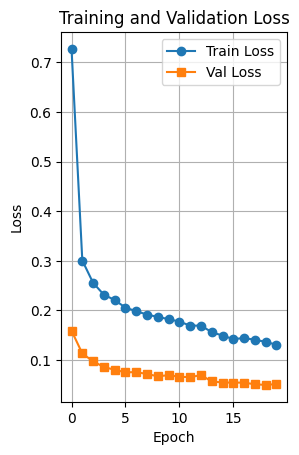

In [ ]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

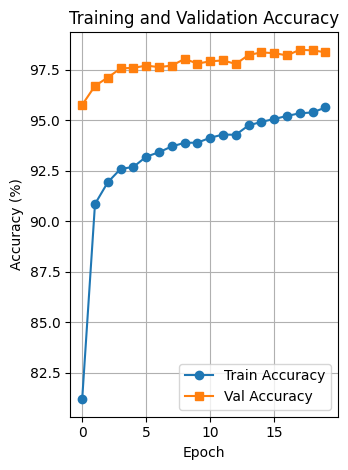


Training history plot saved as 'training_history.png'


In [ ]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining history plot saved as 'training_history.png'")

Test Predict Function

In [ ]:
def predict_disease(image_path, model, transform, device, top_k=3):
    """
    Predict disease from image with top-k predictions
    """
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)

        # Get top-k predictions
        top_probs, top_indices = torch.topk(probabilities, k=min(top_k, num_classes))

        results = []
        for prob, idx in zip(top_probs[0], top_indices[0]):
            disease_name = idx_to_class[idx.item()]
            confidence = prob.item()

            results.append({
                'disease': disease_name,
                'confidence': confidence,
                'confidence_percentage': f"{confidence * 100:.2f}%",
                'disease_info': DISEASE_INFO.get(disease_name, {})
            })

    return results

In [ ]:
# Test prediction
print("\n" + "="*60)
print("Testing Prediction Function")
print("="*60)


Testing Prediction Function


In [ ]:
# Get a sample image from validation set
sample_idx = np.random.randint(0, len(val_dataset))
sample_image_path = val_dataset.dataset.imgs[val_dataset.indices[sample_idx]][0]
sample_label = val_dataset.dataset.imgs[val_dataset.indices[sample_idx]][1]

print(f"\nTest Image: {sample_image_path}")
print(f"Actual Label: {idx_to_class[sample_label]}")



Test Image: /content/dataset/plantvillage dataset/color/Soybean___healthy/1cb3c4d0-d775-44ab-94dc-e4ec2f253fd7___RS_HL 5581.JPG
Actual Label: Soybean___healthy


In [ ]:
# Make prediction
predictions = predict_disease(sample_image_path, model, val_transform, DEVICE, top_k=3)

print("\n Prediction Results:")
print("-" * 60)
for i, pred in enumerate(predictions, 1):
    print(f"\n{i}. Disease: {pred['disease']}")
    print(f"   Confidence: {pred['confidence_percentage']}")
    if pred['disease_info']:
        print(f"   Crop Type: {pred['disease_info']['crop_type']}")
        print(f"   Symptoms: {pred['disease_info']['symptoms'][:100]}...")
        print(f"   Treatment: {pred['disease_info']['treatment'][:100]}...")



 Prediction Results:
------------------------------------------------------------

1. Disease: Soybean___healthy
   Confidence: 100.00%
   Crop Type: Soybean
   Symptoms: The Soybean plant appears healthy with no visible signs of disease....
   Treatment: No treatment needed. Continue regular care and monitoring....

2. Disease: Potato___healthy
   Confidence: 0.00%
   Crop Type: Potato
   Symptoms: The Potato plant appears healthy with no visible signs of disease....
   Treatment: No treatment needed. Continue regular care and monitoring....

3. Disease: Pepper,_bell___healthy
   Confidence: 0.00%
   Crop Type: Pepper,_bell
   Symptoms: The Pepper,_bell plant appears healthy with no visible signs of disease....
   Treatment: No treatment needed. Continue regular care and monitoring....


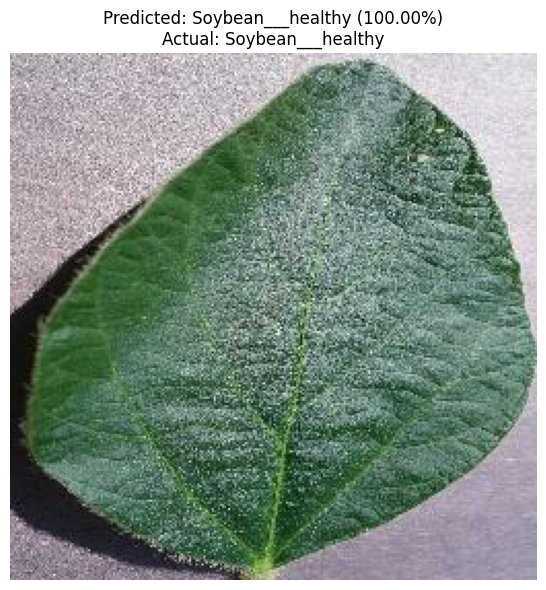


Sample prediction saved as 'sample_prediction.png'


In [ ]:
# Display sample image
plt.figure(figsize=(10, 6))
img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predictions[0]['disease']} ({predictions[0]['confidence_percentage']})\n"
          f"Actual: {idx_to_class[sample_label]}")
plt.tight_layout()
plt.savefig('sample_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSample prediction saved as 'sample_prediction.png'")

Download files for Model Integration

In [ ]:
print("\n" + "="*60)
print("Preparing Files for Download")
print("="*60)

print("\nFiles ready for download:")
print("1. crop_disease_model.pth - Trained model weights")
print("2. class_labels.json - Disease class mappings")
print("3. disease_info.json - Disease information database")
print("4. training_history.json - Training metrics")
print("5. training_history.png - Training visualization")
print("6. sample_prediction.png - Sample prediction result")



Preparing Files for Download

Files ready for download:
1. crop_disease_model.pth - Trained model weights
2. class_labels.json - Disease class mappings
3. disease_info.json - Disease information database
4. training_history.json - Training metrics
5. training_history.png - Training visualization
6. sample_prediction.png - Sample prediction result


In [ ]:
# Download files
files_to_download = [
    'crop_disease_model.pth',
    'class_labels.json',
    'disease_info.json',
    'training_history.json',
    'training_history.png',
    'sample_prediction.png'
]

print("\nDownloading files...")
for file in files_to_download:
    if os.path.exists(file):
        files.download(file)
        print(f"✓ {file} downloaded")

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)
print("\nNext Steps:")
print("1. Download the files above")
print("2. Copy 'crop_disease_model.pth' and 'class_labels.json' to:")
print("   backend/detection/ml_model/")
print("3. Optionally, use 'disease_info.json' to populate your Disease database")
print("4. Your CropSense AI is ready to detect diseases!")
print("="*60)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ crop_disease_model.pth downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ class_labels.json downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ disease_info.json downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ training_history.json downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ training_history.png downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ sample_prediction.png downloaded

✅ Training Complete!

Next Steps:
1. Download the files above
2. Copy 'crop_disease_model.pth' and 'class_labels.json' to:
   backend/detection/ml_model/
3. Optionally, use 'disease_info.json' to populate your Disease database
4. Your CropSense AI is ready to detect diseases!
